In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# He initialisation
he_init = tf.variance_scaling_initializer()

def log_dir(prefix=""):
    """Create a unique directory to save model to."""
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "./models"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

# Prepare Data

The <a href="https://arxiv.org/pdf/1812.01718.pdf">Kuzushiji-MNIST (KMNIST) dataset</a> is a drop-in replacement for the MNIST dataset (70,000 28x28 grayscale images across 10 balanced classes of Japanese Hiragana characters).

In [6]:
X_train = np.load("./Kuzushiji-MNIST/kmnist-train-imgs.npz")['arr_0']
y_train = np.load("./Kuzushiji-MNIST/kmnist-train-labels.npz")['arr_0']

X_test = np.load("./Kuzushiji-MNIST/kmnist-test-imgs.npz")['arr_0']
y_test = np.load("./Kuzushiji-MNIST/kmnist-test-labels.npz")['arr_0']

In [7]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)

X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Plot examples of the Hiragana characters.

In [8]:
chars = pd.read_csv("./Kuzushiji-MNIST/kmnist_classmap.csv", index_col='index')
chars

,codepoint,char
index,,
0,U+304A,お
1,U+304D,き
2,U+3059,す
3,U+3064,つ
4,U+306A,な
5,U+306F,は
6,U+307E,ま
7,U+3084,や
8,U+308C,れ


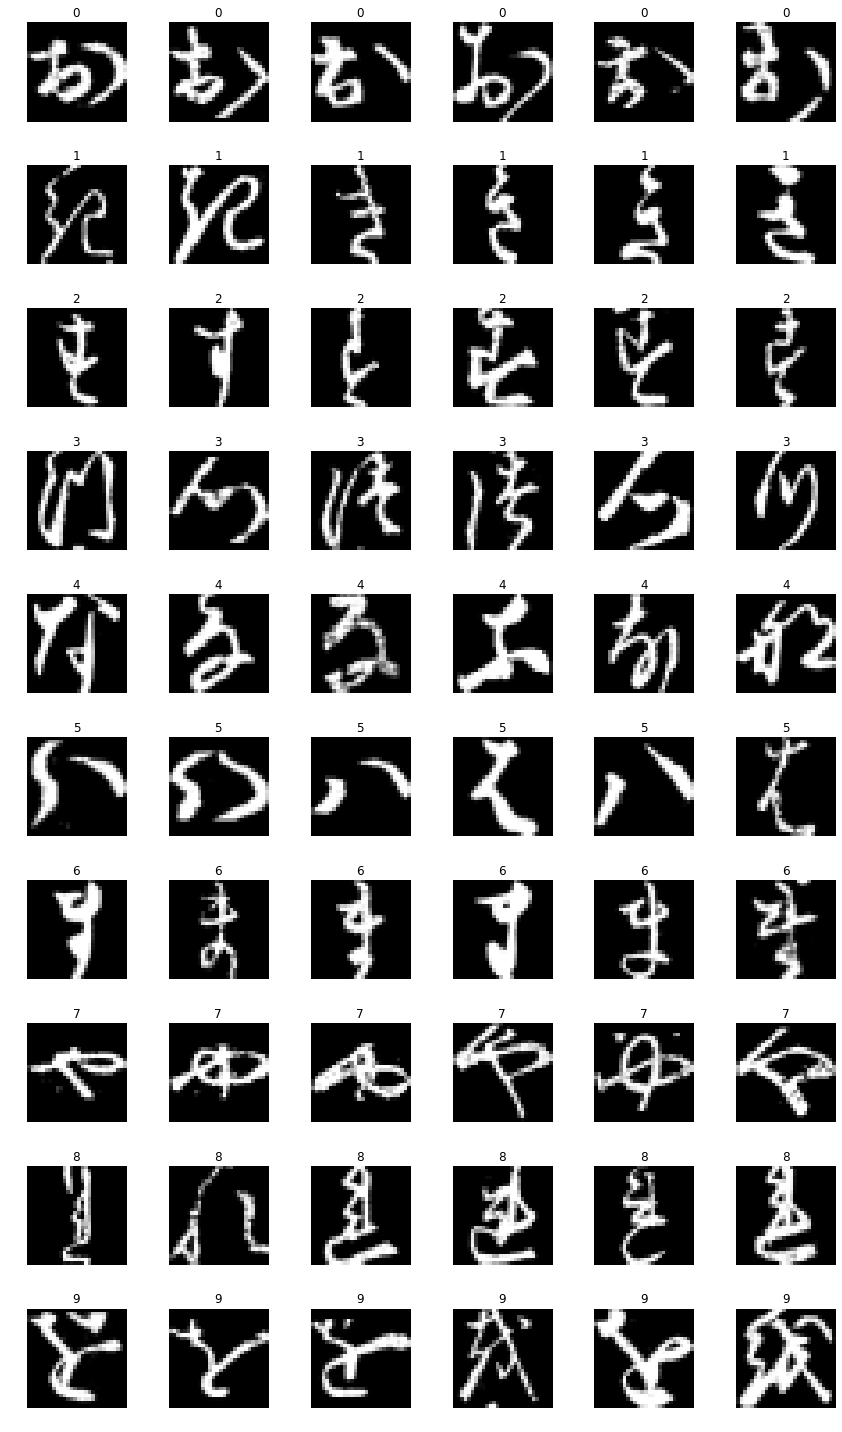

In [9]:
fig, ax = plt.subplots(10, 6, figsize=(12, 20))
for row in range(10):
    label = row
    X = X_train[y_train == label]
    y = y_train[y_train == label]
    for col in range(6):
        ax[row][col].imshow(X[col].reshape(28, 28), cmap='gray')
        ax[row][col].set_title(row)
        ax[row][col].axis('off')
plt.tight_layout()

# Prepare DNN Classifier

Create a class for a configurable DNN classifier. This is a modified version of code borrowed from <a href="https://github.com/ageron/handson-ml">Hands-on Machine Learning with Scikit-Learn and TensorFlow</a>.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None, run_name=""):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self.run_name = run_name
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
        loss_summary = tf.summary.scalar("log_loss", loss)

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        accuracy_summary = tf.summary.scalar("accuracy", accuracy)

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._loss_summary, self._accuracy_summary = loss_summary, accuracy_summary
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            logdir = log_dir(self.run_name)
            file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph, config=config)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val, loss_str, acc_str = sess.run(
                        [self._loss, self._accuracy, self._loss_summary, self._accuracy_summary],
                         feed_dict={self._X: X_valid, self._y: y_valid})
                    file_writer.add_summary(loss_str, epoch)
                    file_writer.add_summary(acc_str, epoch)
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            save_path = self._saver.save(sess, logdir + "model.ckpt")
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

# DNN Architecture

Evaluate the performance of various DNN architectures.

In [8]:
layers = [(3, 50), (4, 50), (5, 50), (6, 50),
          (3, 100), (4, 100), (5, 100), (6, 100),
          (3, 200), (4, 200), (5, 200), (6, 200)]

In [9]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

layer_scores = {}

for layer in layers:
    clear_output() # Clear output between runs
    name = "%sx%s" % (layer[0], layer[1])
    print("Running %s architecture..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, n_hidden_layers=layer[0], n_neurons=layer[1], run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    layer_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", layer_scores)

Running 6x200 architecture...
0	Validation loss: 0.348554	Best loss: 0.348554	Accuracy: 89.98%
1	Validation loss: 0.245201	Best loss: 0.245201	Accuracy: 93.20%
2	Validation loss: 0.294516	Best loss: 0.245201	Accuracy: 93.02%
3	Validation loss: 0.216672	Best loss: 0.216672	Accuracy: 94.22%
4	Validation loss: 0.242256	Best loss: 0.216672	Accuracy: 93.90%
5	Validation loss: 0.214653	Best loss: 0.214653	Accuracy: 94.92%
6	Validation loss: 0.188426	Best loss: 0.188426	Accuracy: 95.56%
7	Validation loss: 0.182600	Best loss: 0.182600	Accuracy: 95.54%
8	Validation loss: 0.225657	Best loss: 0.182600	Accuracy: 95.20%
9	Validation loss: 0.180125	Best loss: 0.180125	Accuracy: 95.90%
10	Validation loss: 0.276134	Best loss: 0.180125	Accuracy: 95.36%
11	Validation loss: 0.250668	Best loss: 0.180125	Accuracy: 95.76%
12	Validation loss: 0.224394	Best loss: 0.180125	Accuracy: 95.82%
13	Validation loss: 0.239081	Best loss: 0.180125	Accuracy: 95.12%
14	Validation loss: 0.232211	Best loss: 0.180125	Accurac

# Optimisers

Evaluate the performance of various optimisers.

In [10]:
from functools import partial

momentum = partial(tf.train.MomentumOptimizer, momentum=0.9)
nesterov = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
rmsprop = partial(tf.train.RMSPropOptimizer, momentum=0.9, decay=0.9, epsilon=1e-10)

optimisers = [tf.train.GradientDescentOptimizer, momentum, nesterov, rmsprop,
              tf.train.AdagradOptimizer, tf.train.AdamOptimizer]
opt_names = ['GD', 'momentum', 'nesterov', 'RMSProp', 'Adagrad', 'Adam']

In [11]:
optimiser_scores = {}

for optimiser, name in zip(optimisers, opt_names):
    clear_output() # Clear output between runs
    print("Running %s optimiser..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=optimiser, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    optimiser_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", optimiser_scores)

Running Adam optimiser...
0	Validation loss: 0.270487	Best loss: 0.270487	Accuracy: 91.36%
1	Validation loss: 0.225808	Best loss: 0.225808	Accuracy: 93.10%
2	Validation loss: 0.194432	Best loss: 0.194432	Accuracy: 94.60%
3	Validation loss: 0.176903	Best loss: 0.176903	Accuracy: 94.92%
4	Validation loss: 0.187586	Best loss: 0.176903	Accuracy: 94.82%
5	Validation loss: 0.203904	Best loss: 0.176903	Accuracy: 94.74%
6	Validation loss: 0.220013	Best loss: 0.176903	Accuracy: 95.02%
7	Validation loss: 0.201967	Best loss: 0.176903	Accuracy: 95.12%
8	Validation loss: 0.206653	Best loss: 0.176903	Accuracy: 95.38%
9	Validation loss: 0.209156	Best loss: 0.176903	Accuracy: 95.04%
10	Validation loss: 0.214532	Best loss: 0.176903	Accuracy: 95.66%
11	Validation loss: 0.233168	Best loss: 0.176903	Accuracy: 95.42%
12	Validation loss: 0.223252	Best loss: 0.176903	Accuracy: 95.82%
13	Validation loss: 0.248622	Best loss: 0.176903	Accuracy: 95.12%
14	Validation loss: 0.244501	Best loss: 0.176903	Accuracy: 9

# Activation Functions

Evaluate the performance of various activation functions.

In [12]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

def selu(z, name=None,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z, name=name))

def gelu(z, name=None):
    # https://arxiv.org/pdf/1606.08415.pdf
    return 0.5*z*(1+tf.tanh(tf.sqrt(2/np.pi)*(z+0.0044715*z**3)))

In [13]:
act_funcs = [tf.nn.relu, leaky_relu, tf.nn.elu, selu, gelu]
act_names = ['ReLU', 'leaky_ReLU', 'ELU', 'SELU', 'GELU']

In [14]:
act_func_scores = {}

for act_func, name in zip(act_funcs, act_names):
    clear_output() # Clear output between runs
    print("Running %s activation function..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            activation=act_func, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    act_func_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", act_func_scores)

Running SELU activation function...
0	Validation loss: 0.739083	Best loss: 0.739083	Accuracy: 77.46%
1	Validation loss: 0.617802	Best loss: 0.617802	Accuracy: 81.36%
2	Validation loss: 0.550612	Best loss: 0.550612	Accuracy: 83.50%
3	Validation loss: 0.504009	Best loss: 0.504009	Accuracy: 84.98%
4	Validation loss: 0.469608	Best loss: 0.469608	Accuracy: 85.86%
5	Validation loss: 0.443545	Best loss: 0.443545	Accuracy: 87.00%
6	Validation loss: 0.415986	Best loss: 0.415986	Accuracy: 87.70%
7	Validation loss: 0.395333	Best loss: 0.395333	Accuracy: 88.32%
8	Validation loss: 0.378501	Best loss: 0.378501	Accuracy: 88.82%
9	Validation loss: 0.362913	Best loss: 0.362913	Accuracy: 89.54%
10	Validation loss: 0.350693	Best loss: 0.350693	Accuracy: 89.88%
11	Validation loss: 0.337992	Best loss: 0.337992	Accuracy: 90.24%
12	Validation loss: 0.326255	Best loss: 0.326255	Accuracy: 90.70%
13	Validation loss: 0.316876	Best loss: 0.316876	Accuracy: 90.62%
14	Validation loss: 0.309859	Best loss: 0.309859	A

# Learning Rates

Evaluate the performance of various learning rates.

In [15]:
# Higher learning rates return errors
learning_rates = [0.001, 0.01, 0.1]

In [16]:
lr_scores = {}

for rate in learning_rates:
    clear_output() # Clear output between runs
    name = "lr_%s" % str(rate).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=rate, optimizer_class=tf.train.GradientDescentOptimizer, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    lr_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", lr_scores)

Running lr_0_1...
0	Validation loss: 0.339599	Best loss: 0.339599	Accuracy: 89.26%
1	Validation loss: 0.234632	Best loss: 0.234632	Accuracy: 92.82%
2	Validation loss: 0.199905	Best loss: 0.199905	Accuracy: 93.90%
3	Validation loss: 0.211594	Best loss: 0.199905	Accuracy: 93.84%
4	Validation loss: 0.203775	Best loss: 0.199905	Accuracy: 94.10%
5	Validation loss: 0.182133	Best loss: 0.182133	Accuracy: 95.08%
6	Validation loss: 0.192336	Best loss: 0.182133	Accuracy: 94.68%
7	Validation loss: 0.212330	Best loss: 0.182133	Accuracy: 94.76%
8	Validation loss: 0.209052	Best loss: 0.182133	Accuracy: 95.18%
9	Validation loss: 0.240708	Best loss: 0.182133	Accuracy: 95.08%
10	Validation loss: 0.233432	Best loss: 0.182133	Accuracy: 95.06%
11	Validation loss: 0.214291	Best loss: 0.182133	Accuracy: 95.24%
12	Validation loss: 0.226963	Best loss: 0.182133	Accuracy: 95.40%
13	Validation loss: 0.226738	Best loss: 0.182133	Accuracy: 95.20%
14	Validation loss: 0.232293	Best loss: 0.182133	Accuracy: 95.14%
15

# Batch Normalised Momentum

Evaluate the performance when using batch normalised momentum.

In [17]:
bnms = [None, 0.3, 0.6, 0.9]

In [18]:
bnm_scores = {}

for bnm in bnms:
    clear_output() # Clear output between runs
    name = "bnm_%s" % str(bnm).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            batch_norm_momentum=bnm, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    bnm_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", bnm_scores)

Running bnm_0_9...
0	Validation loss: 0.705312	Best loss: 0.705312	Accuracy: 79.24%
1	Validation loss: 0.557418	Best loss: 0.557418	Accuracy: 83.32%
2	Validation loss: 0.479528	Best loss: 0.479528	Accuracy: 85.60%
3	Validation loss: 0.425212	Best loss: 0.425212	Accuracy: 87.60%
4	Validation loss: 0.392530	Best loss: 0.392530	Accuracy: 88.38%
5	Validation loss: 0.362577	Best loss: 0.362577	Accuracy: 89.20%
6	Validation loss: 0.334308	Best loss: 0.334308	Accuracy: 90.08%
7	Validation loss: 0.317816	Best loss: 0.317816	Accuracy: 90.78%
8	Validation loss: 0.302108	Best loss: 0.302108	Accuracy: 91.30%
9	Validation loss: 0.286328	Best loss: 0.286328	Accuracy: 91.88%
10	Validation loss: 0.273427	Best loss: 0.273427	Accuracy: 92.02%
11	Validation loss: 0.261411	Best loss: 0.261411	Accuracy: 92.44%
12	Validation loss: 0.255390	Best loss: 0.255390	Accuracy: 92.62%
13	Validation loss: 0.248333	Best loss: 0.248333	Accuracy: 92.74%
14	Validation loss: 0.240004	Best loss: 0.240004	Accuracy: 92.88%
1

# Dropout

Evaluate the performance when using drop out.

In [19]:
dropouts = [None, 0.1, 0.3, 0.5]

In [20]:
dropout_scores = {}

for dropout in dropouts:
    clear_output() # Clear output between runs
    name = "dropout_%s" % str(dropout).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            dropout_rate=dropout, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    dropout_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", dropout_scores)

Running dropout_0_5...
0	Validation loss: 1.757516	Best loss: 1.757516	Accuracy: 40.38%
1	Validation loss: 1.461808	Best loss: 1.461808	Accuracy: 50.34%
2	Validation loss: 1.258615	Best loss: 1.258615	Accuracy: 59.10%
3	Validation loss: 1.116536	Best loss: 1.116536	Accuracy: 64.62%
4	Validation loss: 1.036125	Best loss: 1.036125	Accuracy: 67.28%
5	Validation loss: 0.982409	Best loss: 0.982409	Accuracy: 69.12%
6	Validation loss: 0.945030	Best loss: 0.945030	Accuracy: 70.02%
7	Validation loss: 0.915848	Best loss: 0.915848	Accuracy: 70.98%
8	Validation loss: 0.884702	Best loss: 0.884702	Accuracy: 72.02%
9	Validation loss: 0.863796	Best loss: 0.863796	Accuracy: 72.98%
10	Validation loss: 0.827038	Best loss: 0.827038	Accuracy: 74.48%
11	Validation loss: 0.817515	Best loss: 0.817515	Accuracy: 74.48%
12	Validation loss: 0.801351	Best loss: 0.801351	Accuracy: 74.86%
13	Validation loss: 0.778970	Best loss: 0.778970	Accuracy: 75.64%
14	Validation loss: 0.772141	Best loss: 0.772141	Accuracy: 75.4

124	Validation loss: 0.415827	Best loss: 0.415827	Accuracy: 86.80%
125	Validation loss: 0.416193	Best loss: 0.415827	Accuracy: 87.02%
126	Validation loss: 0.412728	Best loss: 0.412728	Accuracy: 87.20%
127	Validation loss: 0.412975	Best loss: 0.412728	Accuracy: 87.08%
128	Validation loss: 0.412768	Best loss: 0.412728	Accuracy: 87.04%
129	Validation loss: 0.411158	Best loss: 0.411158	Accuracy: 87.26%
130	Validation loss: 0.413435	Best loss: 0.411158	Accuracy: 87.12%
131	Validation loss: 0.408659	Best loss: 0.408659	Accuracy: 87.18%
132	Validation loss: 0.407821	Best loss: 0.407821	Accuracy: 87.10%
133	Validation loss: 0.407313	Best loss: 0.407313	Accuracy: 87.28%
134	Validation loss: 0.407149	Best loss: 0.407149	Accuracy: 87.36%
135	Validation loss: 0.406911	Best loss: 0.406911	Accuracy: 87.26%
136	Validation loss: 0.407181	Best loss: 0.406911	Accuracy: 87.36%
137	Validation loss: 0.406808	Best loss: 0.406808	Accuracy: 87.14%
138	Validation loss: 0.403995	Best loss: 0.403995	Accuracy: 87

247	Validation loss: 0.345283	Best loss: 0.345283	Accuracy: 89.28%
248	Validation loss: 0.346895	Best loss: 0.345283	Accuracy: 89.22%
249	Validation loss: 0.345929	Best loss: 0.345283	Accuracy: 89.40%
250	Validation loss: 0.343816	Best loss: 0.343816	Accuracy: 89.22%
251	Validation loss: 0.345809	Best loss: 0.343816	Accuracy: 89.32%
252	Validation loss: 0.344288	Best loss: 0.343816	Accuracy: 89.18%
253	Validation loss: 0.344639	Best loss: 0.343816	Accuracy: 89.16%
254	Validation loss: 0.346139	Best loss: 0.343816	Accuracy: 89.26%
255	Validation loss: 0.344958	Best loss: 0.343816	Accuracy: 89.34%
256	Validation loss: 0.343494	Best loss: 0.343494	Accuracy: 89.46%
257	Validation loss: 0.344904	Best loss: 0.343494	Accuracy: 89.24%
258	Validation loss: 0.343839	Best loss: 0.343494	Accuracy: 89.16%
259	Validation loss: 0.342436	Best loss: 0.342436	Accuracy: 89.22%
260	Validation loss: 0.339490	Best loss: 0.339490	Accuracy: 89.34%
261	Validation loss: 0.341788	Best loss: 0.339490	Accuracy: 89

370	Validation loss: 0.313275	Best loss: 0.311657	Accuracy: 90.36%
371	Validation loss: 0.312187	Best loss: 0.311657	Accuracy: 90.66%
372	Validation loss: 0.311874	Best loss: 0.311657	Accuracy: 90.42%
373	Validation loss: 0.312037	Best loss: 0.311657	Accuracy: 90.72%
374	Validation loss: 0.311190	Best loss: 0.311190	Accuracy: 90.72%
375	Validation loss: 0.313128	Best loss: 0.311190	Accuracy: 90.60%
376	Validation loss: 0.311953	Best loss: 0.311190	Accuracy: 90.62%
377	Validation loss: 0.310937	Best loss: 0.310937	Accuracy: 90.60%
378	Validation loss: 0.310630	Best loss: 0.310630	Accuracy: 90.58%
379	Validation loss: 0.311725	Best loss: 0.310630	Accuracy: 90.70%
380	Validation loss: 0.310443	Best loss: 0.310443	Accuracy: 90.80%
381	Validation loss: 0.311665	Best loss: 0.310443	Accuracy: 90.50%
382	Validation loss: 0.310955	Best loss: 0.310443	Accuracy: 90.74%
383	Validation loss: 0.310163	Best loss: 0.310163	Accuracy: 90.50%
384	Validation loss: 0.309363	Best loss: 0.309363	Accuracy: 90

493	Validation loss: 0.292594	Best loss: 0.291608	Accuracy: 91.08%
494	Validation loss: 0.291191	Best loss: 0.291191	Accuracy: 91.26%
495	Validation loss: 0.291579	Best loss: 0.291191	Accuracy: 91.18%
496	Validation loss: 0.290174	Best loss: 0.290174	Accuracy: 91.26%
497	Validation loss: 0.290804	Best loss: 0.290174	Accuracy: 91.22%
498	Validation loss: 0.290424	Best loss: 0.290174	Accuracy: 91.24%
499	Validation loss: 0.289326	Best loss: 0.289326	Accuracy: 91.30%
500	Validation loss: 0.289774	Best loss: 0.289326	Accuracy: 91.20%
501	Validation loss: 0.290931	Best loss: 0.289326	Accuracy: 91.28%
502	Validation loss: 0.289668	Best loss: 0.289326	Accuracy: 91.20%
503	Validation loss: 0.290738	Best loss: 0.289326	Accuracy: 91.20%
504	Validation loss: 0.289181	Best loss: 0.289181	Accuracy: 91.26%
505	Validation loss: 0.288426	Best loss: 0.288426	Accuracy: 91.36%
506	Validation loss: 0.290112	Best loss: 0.288426	Accuracy: 91.36%
507	Validation loss: 0.288366	Best loss: 0.288366	Accuracy: 91

616	Validation loss: 0.278867	Best loss: 0.276354	Accuracy: 91.60%
617	Validation loss: 0.278531	Best loss: 0.276354	Accuracy: 91.54%
618	Validation loss: 0.275948	Best loss: 0.275948	Accuracy: 91.74%
619	Validation loss: 0.277899	Best loss: 0.275948	Accuracy: 91.60%
620	Validation loss: 0.276650	Best loss: 0.275948	Accuracy: 91.78%
621	Validation loss: 0.278934	Best loss: 0.275948	Accuracy: 91.66%
622	Validation loss: 0.277203	Best loss: 0.275948	Accuracy: 91.78%
623	Validation loss: 0.279391	Best loss: 0.275948	Accuracy: 91.66%
624	Validation loss: 0.276720	Best loss: 0.275948	Accuracy: 91.80%
625	Validation loss: 0.276812	Best loss: 0.275948	Accuracy: 91.62%
626	Validation loss: 0.277202	Best loss: 0.275948	Accuracy: 91.56%
627	Validation loss: 0.275726	Best loss: 0.275726	Accuracy: 91.76%
628	Validation loss: 0.275909	Best loss: 0.275726	Accuracy: 91.64%
629	Validation loss: 0.276558	Best loss: 0.275726	Accuracy: 91.62%
630	Validation loss: 0.276117	Best loss: 0.275726	Accuracy: 91

739	Validation loss: 0.269134	Best loss: 0.265383	Accuracy: 91.92%
740	Validation loss: 0.266765	Best loss: 0.265383	Accuracy: 92.06%
741	Validation loss: 0.265725	Best loss: 0.265383	Accuracy: 92.06%
742	Validation loss: 0.265633	Best loss: 0.265383	Accuracy: 92.08%
743	Validation loss: 0.265500	Best loss: 0.265383	Accuracy: 92.14%
744	Validation loss: 0.267068	Best loss: 0.265383	Accuracy: 92.10%
745	Validation loss: 0.267182	Best loss: 0.265383	Accuracy: 92.08%
746	Validation loss: 0.265136	Best loss: 0.265136	Accuracy: 92.14%
747	Validation loss: 0.264390	Best loss: 0.264390	Accuracy: 92.16%
748	Validation loss: 0.267595	Best loss: 0.264390	Accuracy: 92.02%
749	Validation loss: 0.267302	Best loss: 0.264390	Accuracy: 92.04%
750	Validation loss: 0.265141	Best loss: 0.264390	Accuracy: 92.06%
751	Validation loss: 0.266862	Best loss: 0.264390	Accuracy: 92.00%
752	Validation loss: 0.265801	Best loss: 0.264390	Accuracy: 92.10%
753	Validation loss: 0.265755	Best loss: 0.264390	Accuracy: 92

# Test Results

In [21]:
print("DNN Architecture Test Scores:")
for model in layer_scores:
    #print(model, layer_scores[model])
    print("\t{0:20}{1:.2f}".format(model, layer_scores[model]))
print()
print("Optimiser Test Scores:")
for model in optimiser_scores:
    print("\t{0:20}{1:.2f}".format(model, optimiser_scores[model]))
print()
print("Activation Function Test Scores:")
for model in act_func_scores:
    print("\t{0:20}{1:.2f}".format(model, act_func_scores[model]))
print()
print("Learning Rate Test Scores:")
for model in lr_scores:
    print("\t{0:20}{1:.2f}".format(model, lr_scores[model]))
print()
print("Batch Normalised Momentum Test Scores:")
for model in bnm_scores:
    print("\t{0:20}{1:.2f}".format(model, bnm_scores[model]))
print()
print("Dropout Test Scores:")
for model in dropout_scores:
    print("\t{0:20}{1:.2f}".format(model, dropout_scores[model]))

DNN Architecture Test Scores:
	3x50                86.81
	4x50                87.68
	5x50                87.37
	6x50                87.47
	3x100               88.22
	4x100               89.56
	5x100               88.15
	6x100               89.20
	3x200               89.26
	4x200               90.62
	5x200               90.56
	6x200               90.51

Optimiser Test Scores:
	GD                  87.52
	momentum            88.17
	nesterov            89.60
	RMSProp             74.80
	Adagrad             86.92
	Adam                89.02

Activation Function Test Scores:
	ReLU                85.33
	leaky_ReLU          85.46
	ELU                 86.67
	SELU                87.09

Learning Rate Test Scores:
	lr_0_001            87.22
	lr_0_01             87.65
	lr_0_1              88.99

Batch Normalised Momentum Test Scores:
	bnm_None            87.10
	bnm_0_3             88.61
	bnm_0_6             88.51
	bnm_0_9             89.50

Dropout Test Scores:
	dropout_None        86.88
	dropout_0_1

### GELU

In [14]:
def gelu(z, name=None):
    # https://arxiv.org/pdf/1606.08415.pdf
    return 0.5*z*(1+tf.tanh(tf.sqrt(2/np.pi)*(z+0.0044715*z**3)))

In [15]:
act_funcs = [gelu]
act_names = ['GELU']

In [16]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

act_func_scores = {}

for act_func, name in zip(act_funcs, act_names):
    clear_output() # Clear output between runs
    print("Running %s activation function..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            activation=act_func, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    act_func_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", act_func_scores)

Running GELU activation function...
0	Validation loss: 2.295154	Best loss: 2.295154	Accuracy: 19.36%
1	Validation loss: 2.281374	Best loss: 2.281374	Accuracy: 29.08%
2	Validation loss: 2.203110	Best loss: 2.203110	Accuracy: 22.22%
3	Validation loss: 1.714168	Best loss: 1.714168	Accuracy: 43.14%
4	Validation loss: 1.222317	Best loss: 1.222317	Accuracy: 60.34%
5	Validation loss: 0.923958	Best loss: 0.923958	Accuracy: 71.12%
6	Validation loss: 0.737626	Best loss: 0.737626	Accuracy: 77.24%
7	Validation loss: 0.651883	Best loss: 0.651883	Accuracy: 79.94%
8	Validation loss: 0.589061	Best loss: 0.589061	Accuracy: 82.02%
9	Validation loss: 0.541711	Best loss: 0.541711	Accuracy: 83.38%
10	Validation loss: 0.509017	Best loss: 0.509017	Accuracy: 84.70%
11	Validation loss: 0.490994	Best loss: 0.490994	Accuracy: 84.88%
12	Validation loss: 0.470136	Best loss: 0.470136	Accuracy: 85.40%
13	Validation loss: 0.454657	Best loss: 0.454657	Accuracy: 86.14%
14	Validation loss: 0.434821	Best loss: 0.434821	A